<a href="https://colab.research.google.com/github/Deok-Hun/Aiffel_Kun/blob/master/Ex_Kaggle_House_Price_rev_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [3]:
os.environ['HOME']=''
print(os.getenv('HOME'))

In [4]:
data_dir = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_3/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
print(train.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
train['date']=train['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


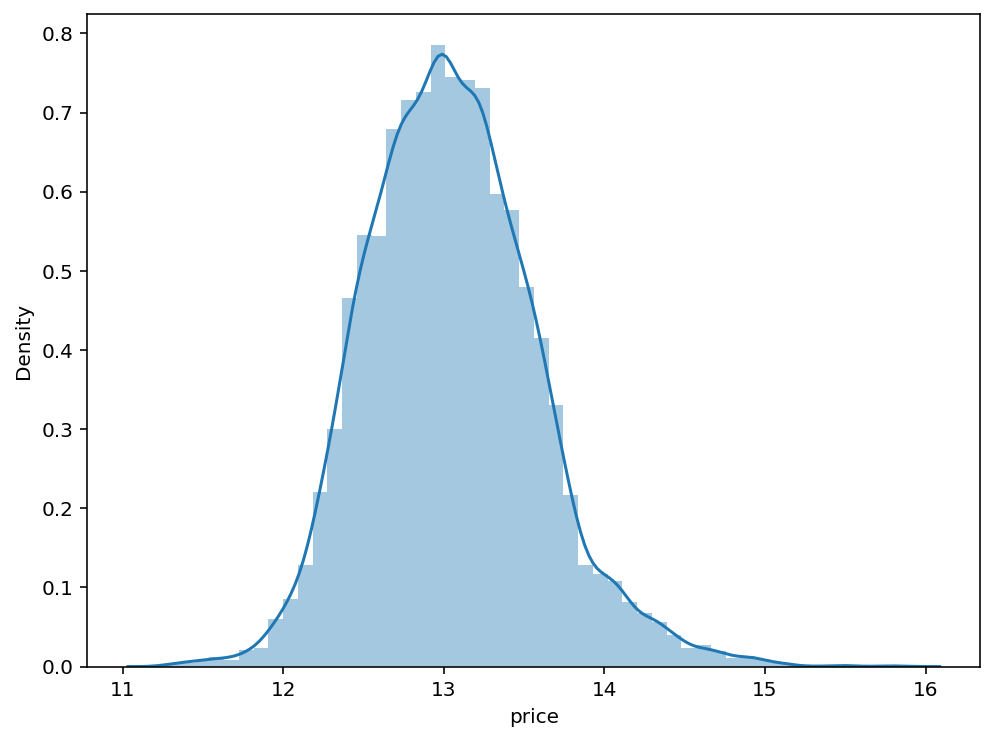

In [8]:
train['price'] = np.log1p(train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

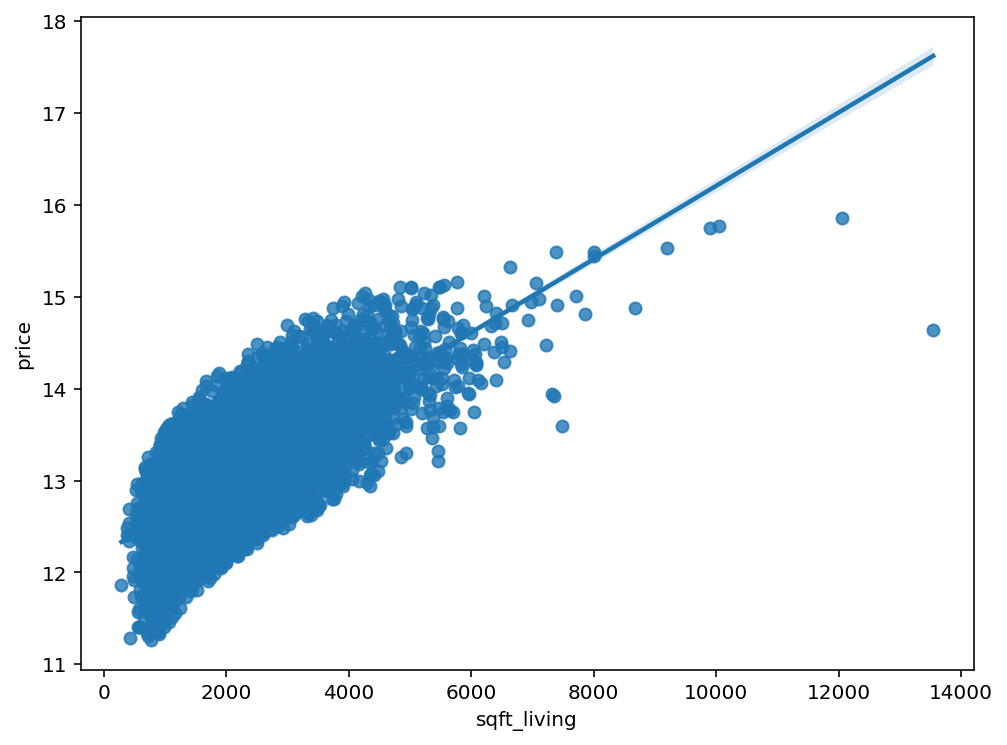

In [9]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [10]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [11]:
train = train.loc[train['id']!=8912]

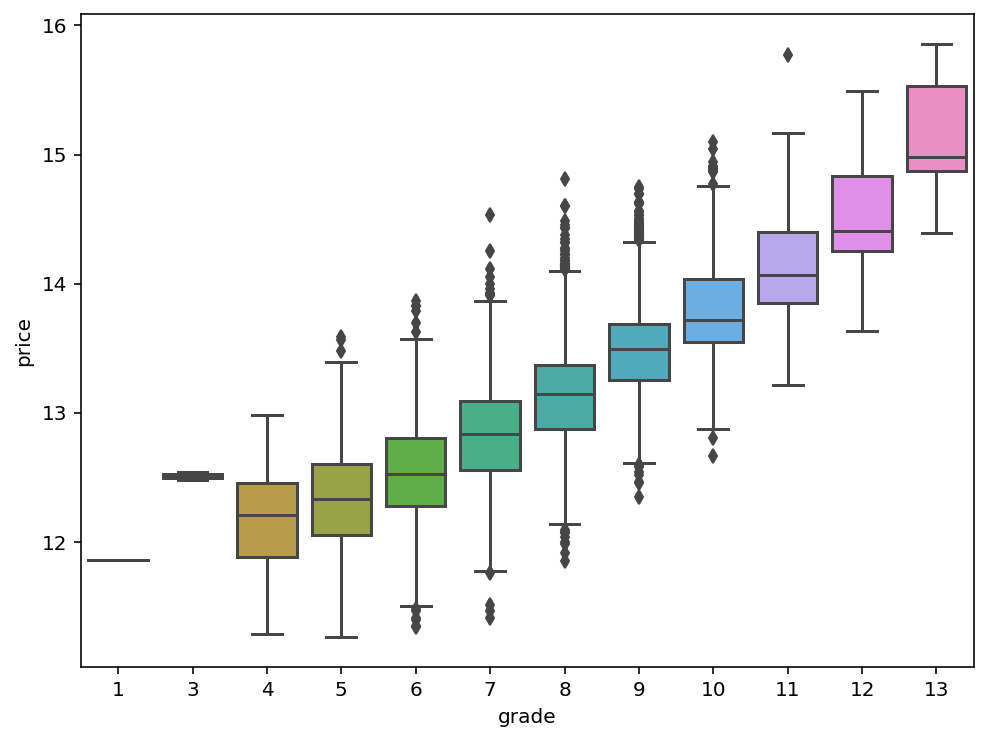

In [12]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [13]:
train.loc[(train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [14]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]

In [15]:
train.loc[(train['price']>2.725) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2,2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,5,201504,13.403777,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
18,18,201411,12.703816,3,2.25,2450,6500,2.0,0,0,...,8,2450,0,1985,0,98030,47.3739,-122.172,2200,6865
20,20,201406,13.750440,3,1.75,2450,2691,2.0,0,0,...,8,1750,700,1915,0,98119,47.6386,-122.360,1760,3573
21,21,201412,13.410547,3,1.00,1400,1581,1.5,0,0,...,8,1400,0,1909,0,98112,47.6221,-122.314,1860,3861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15023,15023,201410,12.765691,4,2.75,2500,5995,2.0,0,0,...,8,2500,0,2008,0,98042,47.3749,-122.107,2530,5988
15028,15028,201504,13.054087,3,2.50,1425,1179,3.0,0,0,...,8,1425,0,2008,0,98125,47.6963,-122.318,1285,1253
15029,15029,201408,13.136761,3,2.50,2270,5536,2.0,0,0,...,8,2270,0,2003,0,98065,47.5389,-121.881,2270,5731
15032,15032,201405,12.793862,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509


In [16]:
train = train.loc[train['id']!=7173]

In [17]:
train.loc[(train['price']>2.8) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
47,47,201409,13.854732,5,3.25,4770,50094,1.0,0,0,...,11,3070,1700,1973,0,98005,47.6525,-122.160,3530,38917
191,191,201505,14.880222,4,3.25,5050,20100,1.5,0,2,...,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060
192,192,201410,14.126666,4,4.75,5310,57346,2.0,0,0,...,11,5310,0,1989,0,98077,47.7285,-122.042,4180,47443
222,222,201406,14.140489,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
275,275,201407,14.115616,5,3.50,4800,14984,2.0,0,2,...,11,3480,1320,1998,0,98006,47.5543,-122.148,4050,19009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,14975,201406,14.096924,4,4.00,4420,16526,2.0,0,0,...,11,4420,0,2013,0,98075,47.5914,-122.027,3510,50447
14988,14988,201408,13.870946,2,1.50,2370,184231,2.0,0,0,...,11,2370,0,2005,0,98045,47.4543,-121.778,3860,151081
14990,14990,201412,14.133965,5,4.50,4350,13405,2.0,0,0,...,11,4350,0,2014,0,98074,47.6018,-122.060,3990,7208
15021,15021,201405,14.016409,4,3.50,4910,9444,1.5,0,0,...,11,3110,1800,2007,0,98074,47.6502,-122.066,4560,11063


In [18]:
train = train.loc[train['id']!=2775]

In [19]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [20]:
test['date']=test['date'].apply(lambda i: i[:6]).astype(int)

In [21]:

del train['id']
del test['id']

In [22]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


In [23]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,2390,7570


In [24]:
for c in train.columns:
  print('{} : {}'.format(c,len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [25]:
for c in test.columns:
  print('{} : {}'.format(c,len(test.loc[pd.isnull(test[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [26]:
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    

In [27]:
train['per_price'] = train['price']/train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

for df in [train,test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [28]:
y=train['price']
del train['price']

In [51]:
del train['per_price']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [31]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [34]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
  
df

[16:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 109015.82784380605,
 'XGBRegressor': 109114.97217264546,
 'LGBMRegressor': 67175.84533024281,
 'RandomForestRegressor': 93281.44184749713}

In [35]:
def get_scores(models,train,y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models,train,y)

[16:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,109114.972173
GradientBoostingRegressor,109015.827844
RandomForestRegressor,93281.441847
LGBMRegressor,67175.845330


In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {'n_estimators':[50,100],'max_depth':[1,10],'boosting':['gbdt'], 'num_iterations':[1000], 'learning_rate':[0.005],}

In [38]:
model = LGBMRegressor(random_state=random_state)

In [39]:
grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=5,verbose=2,n_jobs=5)

grid_model.fit(train,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'boosting': ['gbdt'], 'learning_rate': [0.005],
                         'max_depth': [1, 10], 'n_estimators': [50, 100],
                         'num_iterations': [1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [40]:
params=grid_model.cv_results_['params']
params

[{'boosting': 'gbdt',
  'learning_rate': 0.005,
  'max_depth': 1,
  'n_estimators': 50,
  'num_iterations': 1000},
 {'boosting': 'gbdt',
  'learning_rate': 0.005,
  'max_depth': 1,
  'n_estimators': 100,
  'num_iterations': 1000},
 {'boosting': 'gbdt',
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 50,
  'num_iterations': 1000},
 {'boosting': 'gbdt',
  'learning_rate': 0.005,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iterations': 1000}]

In [41]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07451869, -0.07451869, -0.01192773, -0.01192773])

In [42]:
results = pd.DataFrame(params)
results['score']=score

results

,boosting,learning_rate,max_depth,n_estimators,num_iterations,score
0,gbdt,0.005,1,50,1000,-0.074519
1,gbdt,0.005,1,100,1000,-0.074519
2,gbdt,0.005,10,50,1000,-0.011928
3,gbdt,0.005,10,100,1000,-0.011928


In [43]:
results['RMSLE']=np.sqrt(-1*results['score'])
results=results.sort_values('RMSLE')

results

,boosting,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
2,gbdt,0.005,10,50,1000,-0.011928,0.109214
3,gbdt,0.005,10,100,1000,-0.011928,0.109214
0,gbdt,0.005,1,50,1000,-0.074519,0.272981
1,gbdt,0.005,1,100,1000,-0.074519,0.272981


In [52]:
model = LGBMRegressor(max_depth=10,n_estimators=100,boosting='gbdt', num_iterations=1000, learning_rate=0.05, random_state=random_state) 
model.fit(train,y)
prediction = model.predict(test)
prediction

array([13.17676955, 13.16253692, 14.11720853, ..., 13.07371528,
       12.69760463, 12.97435875])

In [53]:
prediction = np.expm1(prediction)
prediction

array([ 527955.69874779,  520494.70823226, 1352151.78094767, ...,
        476257.13159465,  326962.76400866,  431212.56005171])

In [54]:
data_dir = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_3/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [55]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.279557e+05
1,15036,5.204947e+05
2,15037,1.352152e+06
3,15038,3.081825e+05
4,15039,3.337876e+05


In [56]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.109214')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/Exploration/Exploration_3/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.109214.csv


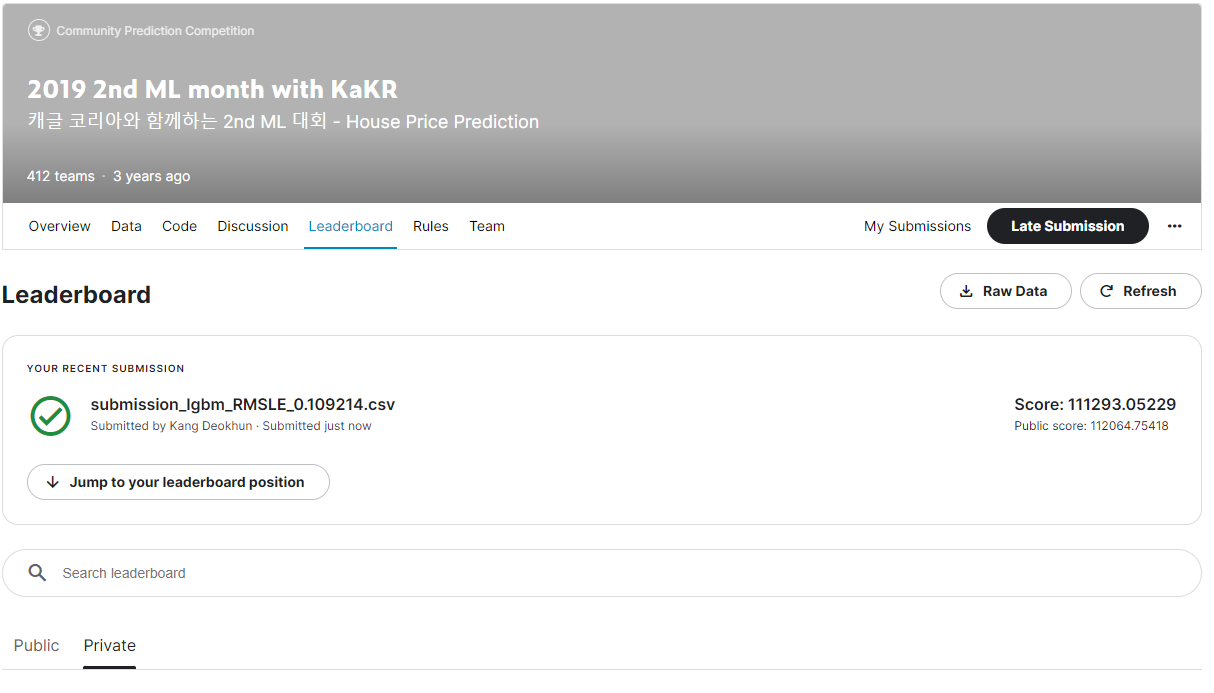

In [57]:
from PIL import Image
import os

image_path = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_3/kaggle_kakr_housing/data/2022-09-21 02;02;14.PNG'

img=Image.open(image_path)
img

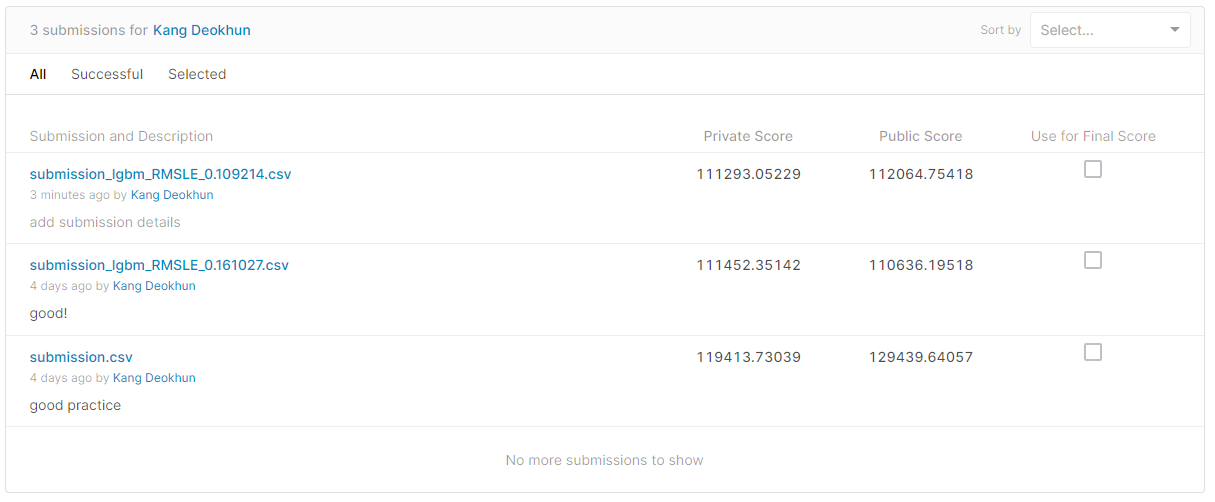

In [58]:
from PIL import Image
import os

image_path = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_3/kaggle_kakr_housing/data/2022-09-21 02;05;23.PNG'

img=Image.open(image_path)
img